# Modelling distributions with regularized JKO scheme and tensor-train decomposition

This notebook summarizes the main principles of the method and demonstrates the application of the code. 

## Entropy regularized JKO scheme

The idea of the method is to construct a sequence of measures $\rho^k$, that successively minimize the $\operatorname{KL(\rho^k|\rho^\infty)}$ between the current estimate and the posterior distribution $\rho^\infty$. 
We also introduce a dynamic that interpolates between the intermediate steps, and will give us an algorithm to produce samples. 

\begin{align}
\rho^{k+1} =  \arg\min\limits_{v,\rho }\int\limits_0^T\int\limits_X {\frac{1}{2}\|v(t,x)\|^2}{\rho(t, x)}\mathrm{d}x\mathrm{d}t &+ \operatorname{KL}(\rho(T,\cdot) | \rho^\infty) \\
\partial_t \rho + \nabla(\rho v) &= \beta\operatorname{\Delta}\rho \\
\rho(0, x) &= \rho^{k}(x) \\
\rho(T, x) &:= \rho^{k+1}(x)
\end{align}

In this PDE-constrained minimization problem, the $\operatorname{KL(\rho^k|\rho^\infty)}$ term penalizes the dissimilarity to the posterior, and the integral provides that the next step is not too far from the current. 
The constraint of the Fokker-Planck equation is defining the interpolating dynamics. The dynamic can be equivalently written as an SDE:

\begin{align}
\mathrm{d}X_t &= v(t, X_t)\mathrm{d}t + \sqrt{2\beta}\mathrm{d}W_t \\
X_0 &\sim \rho^k
\end{align}

or as an ODE:

\begin{align}
\dot X(t) &= \tilde{v}(t, x(t)) \\
\tilde{v}(t, x) &:= v(t, x) - \beta\nabla\log\rho(t, x)
\end{align}

So, if the solution $\rho,v$ is known, one can use this to transform a sample from $\rho^k$ to a sample from $\rho^{k+1}$, by solving one of these equations. 

The important parameters are the timestep $T > 0$ and the regularization factor $\beta > 0$.


## Tensor-Train decomposition

The idea of the package is to use a discretization on the grid. 
This wouldn't normally be possible in a dimension $>3$, but we use a Tensor-Train decomposition to compress the data.

In TT format, a tensor $A \in \mathbb{R}^{N_1 \times \cdots \times N_d}$ is (approximately) represented as:
$$
A_{i_1\cdots i_d} \approx A^1_{i_1 r_1} A^2_{r_1 i_2 r_2} \cdots A^d_{r_{d-1}i_d}
$$
with 3-tensors $A^k \in \mathbb{R}^{r_{k-1} \times i_k \times r_k}$ called the components, $r_k$ ranks and $r = \max_k r_k, $ being the rank of the Tensor Train. 
Certain structured data can be represented with Tensor Train of low rank, allowing to significantly reduce the storage cost ($O(dNr^2)$ versus $O(N^d)$ for the full tensor).
Some of the linear algebra operations can be performed in the low rank format.
The cross-approximation algorithm allows to construct a low-rank approximation to a tensor by accessing its values only for a smaller set of indices, which is useful to reconstruct functionally-defined tensors.

## Solver

Let's try the method out!

In [1]:
# TODO: proper installation, remove this...

import sys

sys.path.append("../../../src/")

In [2]:
from rJKOtt import *
from rJKOtt.utility import tt_independent_gaussians

In [3]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

%matplotlib inline
import teneva

### Target distribution

As a target for this test, we choose a Gaussian mixture distribution.
Each component is a normal distribution $\mathcal{N}(m_i, \sigma I_d)$ and they are mixed with equal weights, with $m_i$ generated randomly. One also has to choose the bounds for the grid; in this example, it's chosen so that the grid fits the $3\sigma$ interval of each of the components of the mixture.

In [4]:
N_comp = 5
dim = 6
L = 3.0  # Choose the grid bounds
N = [
    100,
] * dim  # Number of nodes in the grid; can be chosen independently in each direction, but we take uniforn
grid = Grid(-L, L, N, dim)  # Initialize the grid
means = uniform.rvs(loc=-L / 2, scale=L / 1, size=(N_comp, dim), random_state=1)
sigma = 0.5
covariance = [
    np.eye(
        dim,
    )
    * sigma**2
] * N_comp

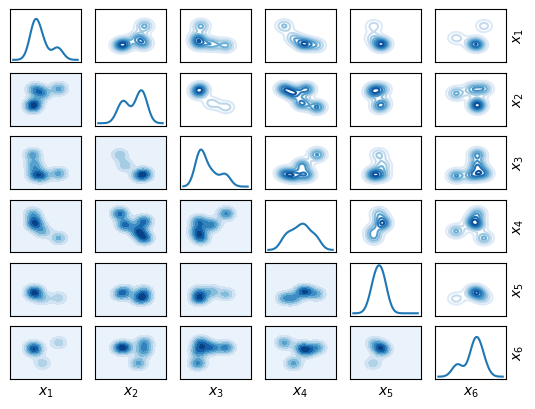

In [5]:
gm = GaussianMixture(
    grid,
    means,
    covariance,
)  # Convenience class for
fig, axs = gm.plot_matrix_marginals(
    sym=True,
    contour_kwargs={
        "cmap": "Blues",
    },
    plot_kwargs={"color": "tab:blue", "label": r"$\rho_\infty$"},
)

### Initial distribution

As a starting distribution $\rho^0$ we choose the Standart Normal (up to constraining it on the box defined by the bounds).

In [6]:
tt_init = TensorTrainDistribution.gaussian(grid)

Let's plot them together:

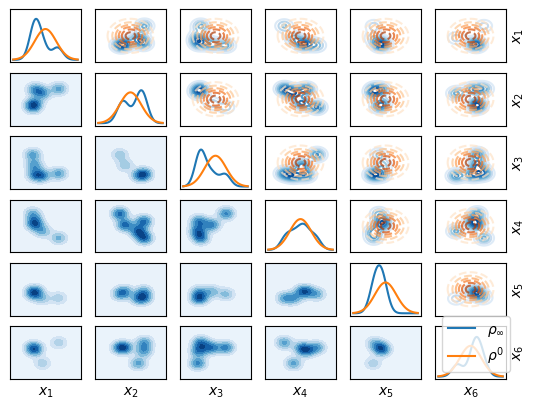

In [7]:
fig, axs = tt_init.plot_matrix_marginals(
    axs=axs,
    contour_kwargs={"cmap": "Oranges", "linestyles": "dashed", "alpha": 0.7},
    plot_kwargs={
        "color": "tab:orange",
        "label": r"$\rho^0$",
    },
)
axs[-1, -1].legend()
fig

### The solver

For the discrete solution, the first-order optimality conditions are written and, with a change of variables, we arrive at the system of PDEs

\begin{align}
\partial_t \hat{\eta} &= \beta\Delta\hat{\eta} \\
\partial_t {\eta} &= -\beta\Delta\eta \\
\hat\eta (0) &= \frac{\rho^k(x)}{\eta(0)}\\
\eta(T) &= \left(\frac{\rho_\infty}{\hat\eta(T)} \right)^{\frac{1}{1 + 2\beta}}  \\
\rho(t, x) &= \eta(t, x)\cdot \hat\eta(t, x),\\
v(t, x) &= 2\beta\nabla\log\eta(t, x)
\end{align}

The variables $\eta, \hat\eta$ are then represented on a grid.
The finite-difference solution of the heat equations is computed efficiently by applying one-dimensional solution operators $e^{\beta T \Delta}$ to the components of the tensor train.
Given pointwise evaluations of one of the potentials. 
The initial and terminal conditions are satisfied approximately by reconstructing the right-hand sides with cross-approximation.

During the cross-approximation of the terminal condition, the posterior is evaluated.
In a practical Bayesian inversion application, this call invokes the computationally intensive forward model, so we suggest to cache these calls to save computational effort. 

Additional problem is the coupling of the system. 
For that, the fixed-point approach is used. 
Starting with the initial guess for one of the potentials $\eta$, we can compute the solution of the PDE, get the boundary value for the other potential $\hat\eta$ from the BC, solve PDE again and, from the terminal condition get the value $\tilde\eta$ that, for the coupled solution, should be equal to the initial guess.

We reformulate the coupling problem as a fixed point problem for this operator, also represented as a cycle below:


$$
\Large
\begin{CD}
\eta_{m, 0}           @<{e^{\beta T \Delta}\cdot }<<    \eta_{m, T} \\
@V{\hat\eta_{m, 0}} = \frac{\rho^k}{\eta_{m,0}}VV             @AA{\tilde\eta_{m, T} = \left(\frac{\rho_\infty}{\hat\eta_{m, T}} \right)^{\frac{1}{1 + 2\beta}} 
}A \\
\hat\eta_{m, 0}        @>>{e^{\beta T \Delta}\cdot }>     \hat\eta_{m, T}
\end{CD}
$$

The most basic approach would be Picard iteration, i.e. iterating the cycle over and over, taking $\eta_{m+1} = \tilde\eta_{m}$.
It is, however, slow, so we implement Anderson's acceleration scheme.

In [8]:
import rJKOtt.TensorTrainSolver

solver = TensorTrainSolver(
    gm.density,  # The function x -> rho_infty(x)
    tt_init,  # Info on the grid and the initial distribution (in TT)
    TensorTrainSolverParams(),  # Solver's parameters; for the most of them, defaults are OK
)

Unfortunately, at the current stage the solver has a lot of parameters that can't be chosen automatically. For the most, defaults are ok, but we set the important ones below

In [9]:
solver.params.max_rank = 5  # Max TT rank for all the represented variables
solver.params.cross_validation_rtol = 1e-8
# Early stopping criterion for the cross approximation
solver.params.fp_stopping_rtol = 1e-8
# Early stopping criterion for the fixed-point iterations. Set smaller in order to compute KL_est more accurately
solver.params.fp_relaxation = 0.9
# Relaxation factor for the fixed-point method. Default should be ok, make smaller if FP doesn't converge

At least for the simple distributions without strong concentration, a good approximation can actually be obtained in one step.
Regularization factor $\beta$ controls the quality (increase to get a "blurrier" approximation).
The time step $T$ should be chosen large enough so that $\beta T \approx 1\dots100$

In [10]:
_, rel_errors, _, _ = solver.step(1e-4, 1e5, save_history=True)

Initializing FP with method=2_anderson
	Solving initial condition  ranks= [ 1  7  7  3  3  3  1] dt=2.95e-02 n_calls=   12800 stop_condition='e_vld'
	Rounding                   ranks= [ 1  1  1  1  1  1  1] dt=3.70e-03
	Solving terminal condition 

/home/aksenov/miniconda3/envs/teneva_test/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/aksenov/miniconda3/envs/teneva_test/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


ranks= [ 1 16 16 13 13 13  1] dt=9.42e+00 n_calls=  383100 stop_condition='m'
	Rounding                   ranks= [ 1  5  5  5  5  5  1] dt=3.49e-03
Starting FP step 1 rel_err inf
	Solving initial condition  ranks= [ 1  7  7  3  3  3  1] dt=2.54e-02 n_calls=   12800 stop_condition='e_vld'
	Rounding                   ranks= [ 1  1  1  1  1  1  1] dt=8.94e-04
	Solving terminal condition ranks= [ 1 16 16 13 13 13  1] dt=2.21e+00 n_calls=  383100 stop_condition='m'
	Rounding                   ranks= [ 1  5  5  5  5  5  1] dt=3.55e-03
Starting FP step 2 rel_err 1.74e+01
	Solving initial condition  ranks= [ 1  9  9  9  9  9  1] dt=2.36e-01 n_calls=  104000 stop_condition='e'
	Rounding                   ranks= [ 1  5  5  5  5  5  1] dt=4.53e-03
	Solving terminal condition ranks= [ 1 16 16 13 13 13  1] dt=8.61e+00 n_calls=  383100 stop_condition='m'
	Rounding                   ranks= [ 1  5  5  5  5  5  1] dt=3.75e-03
Starting FP step 3 rel_err 1.10e-01
	Solving initial condition  ranks= [ 1  9

In [11]:
print(
    f"KL error (w. posterior calls): {solver.KLs[-1]:.2e}\nKL estimate (no posterior calls): {solver.KLs_est[-1]:.2e}"
)

KL error (w. posterior calls): 0.00e+00
KL estimate (no posterior calls): 9.49e-05


One can study the convergence of the FP method

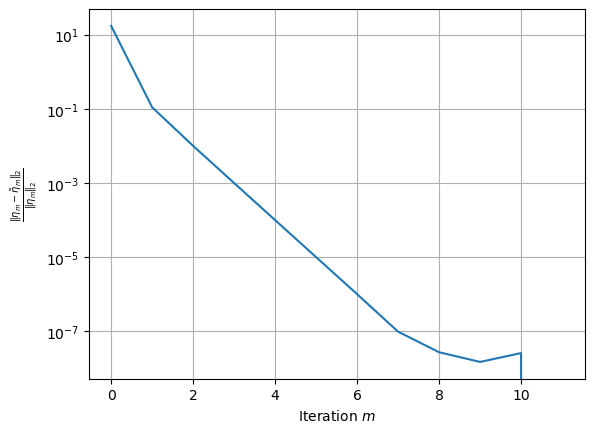

In [12]:
plt.plot(rel_errors)
plt.yscale("log")
plt.ylabel(r"$\frac{\|\eta_m - \tilde\eta_m\|_2}{\|\eta_m\|_2}$")
plt.xlabel("Iteration $m$")
plt.grid(True)

### Sampling

With the converged soultion, the interpolating dynamics can be used to produce samples.
In terms of the parameters, the SDE takes form

$$
\begin{align}
\mathrm{d}X_t &= 2\beta\nabla\log\eta(t, X_t)\ \mathrm{d}t + \sqrt{2\beta}\mathrm{d}W_t \\
X_0 &\sim \rho^k
\end{align}
$$

and the ODE:

$$
\dot{x}(t) = \beta\nabla\left(\log\eta(t, x(t)) - \log\hat\eta(t, x(t))\right) 
$$

Using ODE is more advantageous due to existence of methods with high order and adaptive choice of step size.
However, in the current application, the ODE becomes stiff towards the time interval, and the solution exhibits numerical artefacts. Our solution is for each timestep to run the ODE dynamic for the time $T(1 - \varepsilon)$ (approximately with RK45) and for the last $T\varepsilon$ use the SDE dynamic (with Euler-Maruyama). 


In [13]:
x0 = np.random.randn(300, dim)

solver.params.sampling_sde_fraction = 1e-3
solver.params.sampling_n_euler_maruyama_steps = 50

sample_tt = solver.sample(x0)
sample_ref = gm.sample(300)

When the sample is ready, let's plot the result (marginals of two parameters, not of all for better visibility)

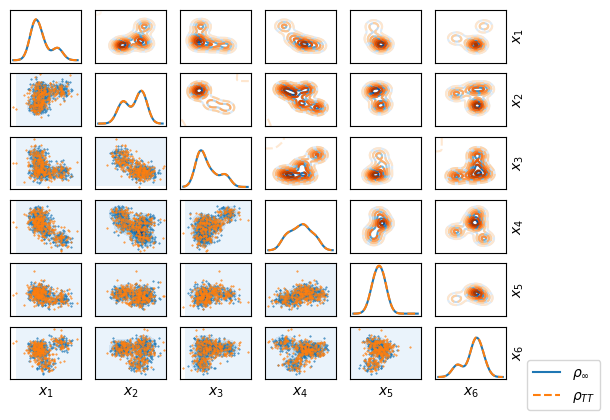

In [14]:
fig, axs = gm.plot_matrix_marginals(
    sym=True,
    sample=sample_ref,
    scatter_args=[0.2],
    scatter_kwargs={"c": "tab:blue"},
    contour_kwargs={
        "cmap": "Blues",
    },
    plot_kwargs={"color": "tab:blue", "label": r"$\rho_\infty$"},
)


tt_distr = solver.get_current_distribution()
tt_distr.plot_matrix_marginals(
    axs=axs,
    sample=sample_tt,
    scatter_args=[0.2],
    scatter_kwargs={"color": "tab:orange"},
    contour_kwargs={
        "cmap": "Oranges",
        "linestyles": "dashed",
    },
    plot_kwargs={"color": "tab:orange", "label": r"$\rho_{TT}$", "linestyle": "--"},
)
axs[-1, -1].legend(bbox_to_anchor=(1.2, 0.5))

Having the reference sample, it makes sense to compare it to the TT sample using OT-based distances.
But, since different random samples from the same measure define different empirical measures, there is the additional error.
This error decreases with the size of the sample, but cannot be efficiently reduced to near-zero values.
One of the ways is to compute multiple independent samples from TT and reference and OT distances between them, and compare to distances between samples, drawn independently from the reference.

In [15]:
from geomloss import SamplesLoss
import torch

_S2dist = SamplesLoss(blur=0.1)  # Sinkhorn distance with regularization 0.1
S2dist = lambda s1, s2: _S2dist(torch.from_numpy(s1), torch.from_numpy(s2))

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [16]:
solver.params.sampling_n_euler_maruyama_steps = 100
solver.params.sampling_sde_fraction = 5e-3

n_draws = 20
n_samples = 100  # Number of samples in each draw

samples_tt = [solver.sample(np.random.randn(n_samples, dim)) for _ in range(n_draws)]
samples_ref = [gm.sample(n_samples) for _ in range(2 * n_draws)]

dist_tt_ref = [S2dist(s_tt, s_ref) for s_tt, s_ref in zip(samples_ref, samples_tt)]
dist_ref_ref = [S2dist(s1, s2) for s1, s2 in zip(samples_ref, samples_ref[n_draws:])]

/home/aksenov/miniconda3/envs/teneva_test/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/aksenov/miniconda3/envs/teneva_test/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


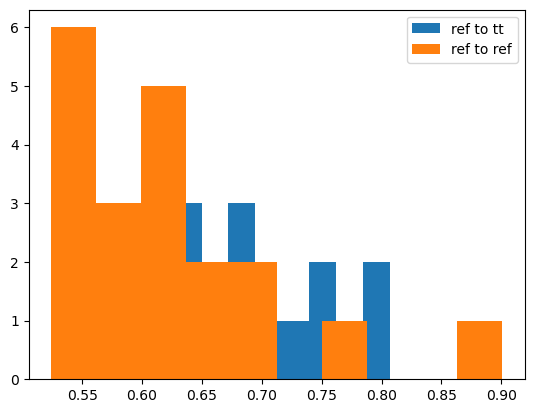

In [17]:
plt.hist(dist_tt_ref, label="ref to tt")
plt.hist(dist_ref_ref, label="ref to ref")
plt.legend()

In [18]:
labels = ["tt_ref", "ref_ref"]
for arr, l in zip([dist_tt_ref, dist_ref_ref], labels):
    arr = np.array(arr)
    print(f"{l} {arr.mean():.2f}+-{arr.std():.2f}")

tt_ref 0.68+-0.07
ref_ref 0.62+-0.09


Looking at the histogram we can see adequate overlap of the distributions.
We can quantify their similarity by computing an OT distance between them ("Double Sinkhorn").
One can see that it's close to zero.

In [19]:
import ot

print(f"{ot.lp.emd2_1d(dist_tt_ref, dist_ref_ref):.2e}")
# Wasserstein distance between distributions of distances

4.89e-03
